In [1]:
%matplotlib inline

In [13]:
from Bio import Phylo
# from io import StringIO
import numpy as np

from matplotlib import pyplot as plt
import random

In [94]:
def rel_time_AJH(tree):
    """
    This closely (exactly?) follows the original implementation but note that the explanation
    of the original algorithm fails to mention what happens with zero length branches which of course
    give zero division errors"""
    depth_dict = tree.depths(unit_branch_lengths=True)
    for key in tree.get_terminals():
        del depth_dict[key]

    inv_depth_dict = {}
    for key,val in depth_dict.items():
        try:
            inv_depth_dict[val].append(key)
        except KeyError:
            inv_depth_dict[val] = [key]
            
            
    for depth in range(max(list(inv_depth_dict.keys())), -1, -1):
        for clade in inv_depth_dict[depth]:
            temp = clade.depths()
            lens = [temp[term]-clade.branch_length for term in clade.get_terminals()]
            for ds_clade in clade.clades:
                ds_lens = [temp[term]-clade.branch_length for term in ds_clade.get_terminals()]
                if np.mean(lens) > 0:
                    ds_clade.rate = np.mean(ds_lens) / np.mean(lens)
                else:
                    ds_clade.rate = 0.
                for all_ds in ds_clade.get_terminals() + ds_clade.get_nonterminals():
                    if all_ds == ds_clade:
                        pass
                    else:
                        all_ds.rate = all_ds.rate*ds_clade.rate
    return tree


def colless_I(tree):
    vals = []
    for internal in tree.get_nonterminals():
        vals.append(np.abs(len(internal.clades[0].get_terminals())-len(internal.clades[1].get_terminals())))
    return np.sum(vals)

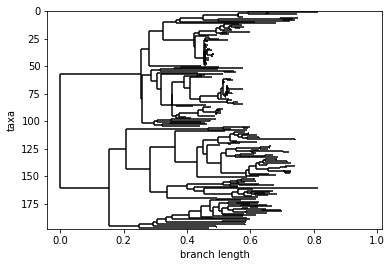

In [95]:
###Real trees
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick', rooted=True)
tree = Phylo.read('/Users/adamhockenberry/Projects/Tree_rooting_analysis/Data/OMA_group_data/'
                  'eukaryotes/processed_OMA_trees/OMAGroup_479938.treefile.RootedNoZero.MPAJH', 'newick', rooted=True)
bls = [i.branch_length for i in tree.get_terminals() if i.branch_length > 0.] + [10e-6]
min_bl = np.min(bls)/1000
for i in tree.get_terminals():
    if i.branch_length == 0.:
        i.branch_length = min_bl




counter=0
for internal in tree.get_nonterminals():
    internal.name = 'Int_{}'.format(counter)
    counter += 1
tree.root.branch_length = 0.0

Phylo.draw(tree, label_func=lambda x: None)

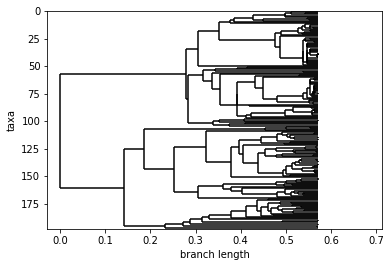

In [96]:
tree = rel_time_AJH(tree)

for node in tree.get_terminals() + tree.get_nonterminals():
    if node == tree.root:
        continue
    node.branch_length = node.branch_length/node.rate
    
Phylo.draw(tree, label_func=lambda x: None)

In [6]:
Phylo.write(tree, './test_reltime_tree.newick', format='newick')

1

In [7]:
depth_dict = tree.depths()
mean_nonterm_depth = np.mean([depth_dict[i] for i in tree.get_nonterminals()])
print(mean_nonterm_depth, len(tree.get_terminals()))

0.48898499797816875 197


# A stochastic but slow way to create different median divergence times

This is *in lieu* of anything more systematic that I could think of. I really think any greedy algorithm will fail

In [97]:
starting_tree_loc = './test_reltime_tree.newick'
starting_tree = Phylo.read(starting_tree_loc, 'newick', rooted=True)
depth_dict = starting_tree.depths()
starting_nt_depths = [depth_dict[i] for i in starting_tree.get_nonterminals()]
best_scores = [np.mean(starting_nt_depths)]
best_trees = [starting_tree]
best_colless = [colless_I(starting_tree)]

for i in range(20):
    print(i)
    target = 50

    tree = Phylo.read(starting_tree_loc, 'newick', rooted=True)

    depth_dict = tree.depths()
    nt_depths = [depth_dict[i] for i in tree.get_nonterminals()]
    print(np.mean(nt_depths), len(tree.get_terminals()))


    counter = 0
    while len(tree.get_terminals()) > target:
        counter += 1
        choice = random.choice(tree.get_terminals()+tree.get_nonterminals())
        mean_nt_depth = np.mean([depth_dict[i] for i in tree.get_nonterminals()])

        if choice in tree.get_terminals():
            node_path = tree.get_path(choice)
            if len(node_path) == 1:
                pass
            else:
                parent = node_path[-2]
                if depth_dict[parent] < mean_nt_depth:
                    tree.prune(choice)
                else:
                    pass
        elif choice in tree.get_nonterminals():
            if choice == tree.root:
                pass
            elif (len(tree.get_terminals()) - len(choice.get_terminals()) + 1) < target:
                pass
            elif depth_dict[choice] > mean_nt_depth:
                pass 
            else:
                removal_depths = choice.depths(unit_branch_lengths=True)
                for i in choice.get_nonterminals():
                    del removal_depths[i]
                removal_depths = removal_depths.items()
                removal_depths = sorted(removal_depths, key=lambda x: x[1])
                for i,j in removal_depths[1:]:
                    tree.prune(i)
        if counter > 300:###Arbitrary to prevent getting stuck
            break
    mean_nt_depth = np.mean([depth_dict[i] for i in tree.get_nonterminals()])
    if mean_nt_depth > np.mean(starting_nt_depths):
        best_scores.append(mean_nt_depth)
        best_trees.append(tree)
    print(np.mean(mean_nt_depth), len(tree.get_terminals()))
    print('######')

0
0.48898520408163265 197
0.4868710204081632 50
######
1
0.48898520408163265 197
0.5115014285714287 50
######
2
0.48898520408163265 197
0.49878122448979595 50
######
3
0.48898520408163265 197
0.5212810204081634 50
######
4
0.48898520408163265 197
0.5065077551020409 50
######
5
0.48898520408163265 197
0.5013267346938777 50
######
6
0.48898520408163265 197
0.48909387755102046 50
######
7
0.48898520408163265 197
0.48519530612244893 50
######
8
0.48898520408163265 197
0.43634469387755104 50
######
9
0.48898520408163265 197
0.4735336734693878 50
######
10
0.48898520408163265 197
0.4629463265306123 50
######
11
0.48898520408163265 197
0.5038377551020409 50
######
12
0.48898520408163265 197
0.4468020408163265 50
######
13
0.48898520408163265 197
0.48838000000000004 50
######
14
0.48898520408163265 197
0.48764326530612245 50
######
15
0.48898520408163265 197
0.47536040816326536 50
######
16
0.48898520408163265 197
0.46652061224489794 50
######
17
0.48898520408163265 197
0.4441406122448979 50
#

In [98]:
combined = list(zip(best_trees, best_score))
combined = sorted(combined, key=lambda x: x[1])[::-1]
best_trees, best_scores = list(zip(*combined))

In [100]:
for i_tree in best_trees:
    print(colless_I(i_tree))

360
357
332
347
323
270
318
253
320
1248


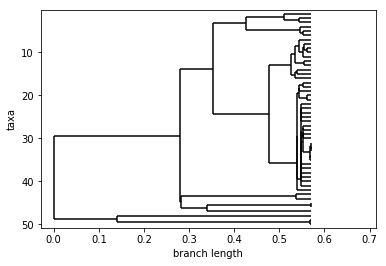

In [101]:
Phylo.draw(best_trees[5], label_func=lambda x: None)

In [84]:
depth_dict = best_trees[0].depths()
starting_nt_depths = [depth_dict[i] for i in best_trees[0].get_nonterminals()]
print(np.mean(starting_nt_depths), np.median(starting_nt_depths), len(best_trees[0].get_terminals()))

0.5110589795918369 0.5476900000000001 50


(array([0.02040816, 0.02040816, 0.04081633, 0.04081633, 0.06122449,
        0.08163265, 0.10204082, 0.16326531, 0.44897959, 1.        ]),
 array([0.      , 0.057075, 0.11415 , 0.171225, 0.2283  , 0.285375,
        0.34245 , 0.399525, 0.4566  , 0.513675, 0.57075 ]),
 <a list of 1 Patch objects>)

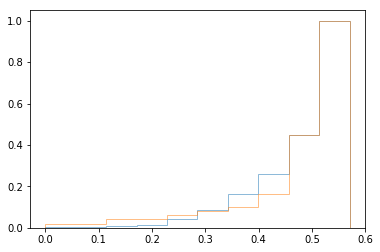

In [91]:
best_index = 5
depth_dict = starting_tree.depths()
best_tree_depth_dict = best_trees[best_index].depths()


fig, ax = plt.subplots()
# ax.hist([depth_dict[i] for i in starting_tree.get_nonterminals()], alpha=0.5, normed=True)
# ax.hist([best_tree_depth_dict[i] for i in best_trees[-1].get_nonterminals()], alpha=0.5, normed=True)
ax.hist([depth_dict[i] for i in starting_tree.get_nonterminals()], alpha=0.5,\
        cumulative=True, normed=True, histtype='step')
ax.hist([best_tree_depth_dict[i] for i in best_trees[best_index].get_nonterminals()], alpha=0.5,\
        cumulative=True, normed=True, histtype='step')



In [93]:
depth_dict[starting_tree.root], best_tree_depth_dict[best_trees[best_index].root]

(0, 0)

In [ ]:
tree.root.clades

In [ ]:
tree.root.clades, tree.root.clades[1].clades

In [ ]:
depth_dict[tree.root.clades[1].clades[0]]